In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.3.1


In [3]:
train_image_path=glob.glob('./data/dc/train/*.jpg')
len(train_image_path)

25000

In [4]:
train_image_label=[int(os.path.basename(p).split('.')[0]=='cat') for p in train_image_path]

train_image_label[:5]

[1, 1, 1, 1, 1]

In [14]:
def load_preprocess_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label,[1])
    return image,label

In [15]:
train_image_ds=tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [16]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_image_ds=train_image_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [17]:
BATCH_SIZE=32
train_count = len(train_image_path)
train_image_ds=train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
train_image_ds=train_image_ds.prefetch(AUTOTUNE)


In [18]:
imgs, lables = next(iter(train_image_ds))
imgs.shape

TensorShape([32, 256, 256, 3])

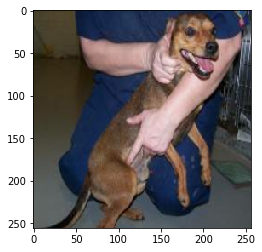

In [19]:
plt.imshow(imgs[0])



In [20]:
lables[0]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>

In [21]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(1024,(3,3),activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 512)       1

In [22]:
pred = model(imgs)
pred.shape

TensorShape([32, 1])

In [24]:
np.array([p[0].numpy() for p in tf.cast(pred>0, tf.int32)])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
np.array([l[0].numpy() for l in lables])

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1])

In [26]:
ls = tf.keras.losses.BinaryCrossentropy()
ls([[0.],[0.],[1.],[1.]],[[1.],[1.],[1.],[1.]])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [28]:
tf.keras.losses.binary_crossentropy([0.,0.,1.,1.],[1.,1.,1.,1.])

<tf.Tensor: shape=(), dtype=float32, numpy=7.6666193>

In [ ]:
optimizer=tf.keras.optimizers.Adam()

In [29]:
epoch_loss_avg=tf.keras.metrics.Mean('train_loss')
train_accuracy=tf.keras.metrics.Accuracy()

In [30]:
def train_step(model,images,labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels,pred)
        grads = t.gradient(loss_step,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
        epoch_loss_avg(loss_step)
        train_accuracy(labels,tf.cast(pred>0,tf.int32))

In [ ]:
train_loss_result=[]
train_acc_result=[]

num_epoch=30

In [ ]:
for epoch in range(num_epoch):
    for imgs_,lables_ in train_image_ds:
        train_step(model,imgs_,lables_)
        print('.',end='')
    print()
    train_loss_result.append(epoch_loss_avg.result())
    train_acc_result.append(train_accuracy.result())
    print("Epoch:{}; loss:{:.3f}; accuracy:{:.3f}".format(
        epoch+1,
        epoch_loss_avg.result(),
        train_accuracy.result()
    ))
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
